In [360]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import DataLoader, TensorDataset, random_split 

from torchmetrics import Accuracy 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
 
from tqdm import tqdm

In [361]:
xtrain = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_train.pt')
ytrain = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_train.pt')

xvalid = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_valid.pt')
yvalid = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_valid.pt')

xtest = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_test.pt')
ytest = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_test.pt')

In [362]:
xtrain.shape, ytrain.shape

(torch.Size([7500, 2, 3000]), torch.Size([7500]))

In [363]:
xvalid.shape, yvalid.shape

(torch.Size([4094, 2, 3000]), torch.Size([4094]))

In [364]:
xtest.shape, ytest.shape

(torch.Size([9850, 2, 3000]), torch.Size([9850]))

In [365]:
#L
xtrain.shape[2]

3000

In [366]:
#F
xtrain.shape[1]

2

In [367]:
xtrain = xtrain.permute(0, 2, 1)
xvalid = xvalid.permute(0, 2, 1)
xtest  = xtest.permute(0, 2, 1)

ytrain = tc.LongTensor(np.array(ytrain))
yvalid = tc.LongTensor(np.array(yvalid))
ytest  = tc.LongTensor(np.array(ytest))

In [368]:
xtrain.shape

torch.Size([7500, 3000, 2])

In [369]:
ytrain.unique()

tensor([0, 1, 2, 3, 4])

In [370]:
mean = xtrain.mean(dim = [0, 1])
std  = xtrain.std(dim = [0, 1])

In [371]:
xtrain = (xtrain - mean)/std 
xvalid = (xvalid - mean)/std 
xtest  = (xtest  - mean)/std

In [372]:
#train_dataset = TensorDataset(xtrain, ytrain)
#valid_dataset = TensorDataset(xvalid, yvalid)
#test_daatset  = TensorDataset(xtest, ytest)

In [373]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)

In [374]:
x, y = next(iter(train_loader))

In [375]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'

In [376]:
device

'cuda'

In [404]:
class RNNModel(nn.Module):
    
    def __init__(self, RNN, input_size, hidden_size, num_layers, bidirectional, dropout, num_classes):
        super().__init__()
        
        self.RNN = RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout, bias = True, batch_first = True)
        self.bn = nn.LazyBatchNorm1d()
        
        self.fc = nn.LazyLinear(num_classes)
        
    def forward(self, x):
        
        y, h = self.RNN(x)
        y = self.bn(y)
        y = y.flatten(1)
        y = self.fc(y)
        
        return y

In [378]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [379]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
        
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            #nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [380]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [423]:
model = RNNModel(nn.RNN, 2, 32, 2, False, 0.5, 5).to(device)

In [424]:
optimizer = optim.SGD(model.parameters(), lr = 0.00005 ,momentum = 0.9, weight_decay = 0)
loss_func = nn.CrossEntropyLoss()

In [425]:
loss_train_hist, acc_train_hist = [], [] 
loss_valid_hist, acc_valid_hist = [], []
best_model = [0]
best_loss = tc.inf

In [426]:
N = 30
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 118/118 [00:02<00:00, 40.35batch/s, Accuracy=23.7, loss=1.7] 


valid loss=1.601, accuracy=16.85

model saved!


Epoch=1: 100%|██████████| 118/118 [00:02<00:00, 40.17batch/s, Accuracy=31.2, loss=1.59]


valid loss=1.772, accuracy=17.73



Epoch=2: 100%|██████████| 118/118 [00:02<00:00, 40.94batch/s, Accuracy=35.1, loss=1.51]


valid loss=1.542, accuracy=27.53

model saved!


Epoch=3: 100%|██████████| 118/118 [00:02<00:00, 41.16batch/s, Accuracy=39.2, loss=1.47]


valid loss=1.719, accuracy=24.06



Epoch=4: 100%|██████████| 118/118 [00:02<00:00, 41.08batch/s, Accuracy=41.2, loss=1.43]


valid loss=1.445, accuracy=36.93

model saved!


Epoch=5: 100%|██████████| 118/118 [00:02<00:00, 41.00batch/s, Accuracy=44.5, loss=1.37]


valid loss=1.471, accuracy=33.12



Epoch=6: 100%|██████████| 118/118 [00:02<00:00, 41.05batch/s, Accuracy=45.9, loss=1.34]


valid loss=1.464, accuracy=33.66



Epoch=7: 100%|██████████| 118/118 [00:02<00:00, 41.06batch/s, Accuracy=47.8, loss=1.28]


valid loss=1.699, accuracy=25.13



Epoch=8: 100%|██████████| 118/118 [00:03<00:00, 37.26batch/s, Accuracy=50.3, loss=1.25]


valid loss=1.639, accuracy=27.53



Epoch=9: 100%|██████████| 118/118 [00:03<00:00, 35.01batch/s, Accuracy=51.3, loss=1.22]


valid loss=2.214, accuracy=23.23



Epoch=10: 100%|██████████| 118/118 [00:03<00:00, 36.21batch/s, Accuracy=53.2, loss=1.19]


valid loss=1.818, accuracy=24.43



Epoch=11: 100%|██████████| 118/118 [00:03<00:00, 37.37batch/s, Accuracy=54.1, loss=1.15]


valid loss=1.634, accuracy=28.97



Epoch=12: 100%|██████████| 118/118 [00:02<00:00, 41.12batch/s, Accuracy=55.6, loss=1.12]


valid loss=1.494, accuracy=35.27



Epoch=13: 100%|██████████| 118/118 [00:02<00:00, 42.03batch/s, Accuracy=57.5, loss=1.08]


valid loss=1.793, accuracy=29.24



Epoch=14: 100%|██████████| 118/118 [00:02<00:00, 39.97batch/s, Accuracy=57.7, loss=1.08]


valid loss=1.49, accuracy=38.37



Epoch=15: 100%|██████████| 118/118 [00:03<00:00, 38.06batch/s, Accuracy=59.7, loss=1.03]


valid loss=1.607, accuracy=33.78



Epoch=16: 100%|██████████| 118/118 [00:02<00:00, 39.82batch/s, Accuracy=60.2, loss=1.01]


valid loss=1.54, accuracy=35.15



Epoch=17: 100%|██████████| 118/118 [00:02<00:00, 39.72batch/s, Accuracy=61.4, loss=0.997]


valid loss=1.493, accuracy=36.81



Epoch=18: 100%|██████████| 118/118 [00:02<00:00, 39.58batch/s, Accuracy=61.5, loss=0.992]


valid loss=1.637, accuracy=33.07



Epoch=19: 100%|██████████| 118/118 [00:03<00:00, 38.69batch/s, Accuracy=62.3, loss=0.973]


valid loss=1.657, accuracy=33.9



Epoch=20: 100%|██████████| 118/118 [00:03<00:00, 38.38batch/s, Accuracy=63.3, loss=0.96] 


valid loss=1.744, accuracy=31.49



Epoch=21: 100%|██████████| 118/118 [00:02<00:00, 40.18batch/s, Accuracy=63.3, loss=0.947]


valid loss=1.656, accuracy=34.42



Epoch=22: 100%|██████████| 118/118 [00:02<00:00, 42.00batch/s, Accuracy=65.1, loss=0.928]


valid loss=1.687, accuracy=32.12



Epoch=23: 100%|██████████| 118/118 [00:02<00:00, 41.69batch/s, Accuracy=64.7, loss=0.922]


valid loss=1.506, accuracy=38.94



Epoch=24: 100%|██████████| 118/118 [00:03<00:00, 37.20batch/s, Accuracy=65.3, loss=0.9]  


valid loss=1.549, accuracy=38.62



Epoch=25: 100%|██████████| 118/118 [00:03<00:00, 33.81batch/s, Accuracy=66, loss=0.898]  


valid loss=1.678, accuracy=35.3



Epoch=26: 100%|██████████| 118/118 [00:04<00:00, 29.09batch/s, Accuracy=66.7, loss=0.875]


valid loss=1.497, accuracy=40.13



Epoch=27: 100%|██████████| 118/118 [00:04<00:00, 29.04batch/s, Accuracy=67.2, loss=0.861]


valid loss=1.488, accuracy=39.4



Epoch=28: 100%|██████████| 118/118 [00:04<00:00, 29.32batch/s, Accuracy=68, loss=0.853]  


valid loss=1.752, accuracy=33.54



Epoch=29: 100%|██████████| 118/118 [00:04<00:00, 28.43batch/s, Accuracy=67.6, loss=0.864]


valid loss=1.596, accuracy=37.91



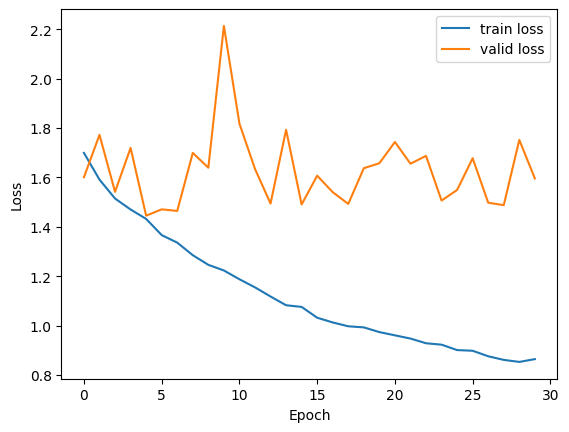

In [427]:
plt.plot(range(N ), loss_train_hist, label = 'train loss')
plt.plot(range(N ), loss_valid_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

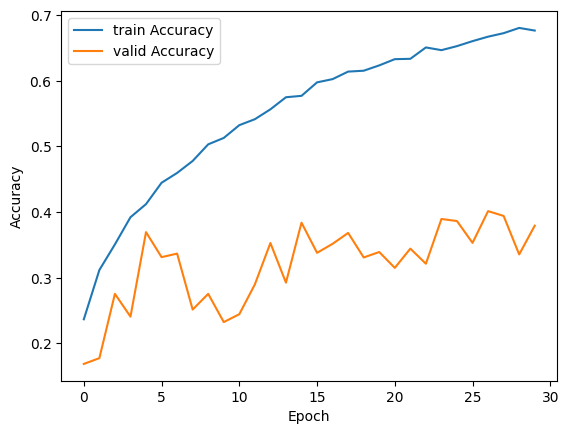

In [428]:
plt.plot(range(N), acc_train_hist, label = 'train Accuracy')
plt.plot(range(N), acc_valid_hist, label = 'valid Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [393]:
model = RNNModel(nn.GRU, 2, 64, 2, False, 0, 5).to(device)

In [394]:
optimizer = optim.SGD(model.parameters(), lr = 0.00001 ,momentum = 0.9, weight_decay = 1e-4)
loss_func = nn.CrossEntropyLoss()

In [395]:
loss_train_hist, acc_train_hist = [], [] 
loss_valid_hist, acc_valid_hist = [], []
best_model = [0]
best_loss = tc.inf

In [396]:
N = 30
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 118/118 [00:07<00:00, 16.85batch/s, Accuracy=24.4, loss=1.64]


valid loss=1.532, accuracy=28.58

model saved!


Epoch=1: 100%|██████████| 118/118 [00:06<00:00, 17.06batch/s, Accuracy=33, loss=1.51]  


valid loss=1.457, accuracy=31.0

model saved!


Epoch=2: 100%|██████████| 118/118 [00:06<00:00, 17.01batch/s, Accuracy=35.7, loss=1.49]


valid loss=1.712, accuracy=17.61



Epoch=3: 100%|██████████| 118/118 [00:06<00:00, 17.15batch/s, Accuracy=38.7, loss=1.44]


valid loss=1.585, accuracy=25.5



Epoch=4: 100%|██████████| 118/118 [00:06<00:00, 17.15batch/s, Accuracy=40.3, loss=1.42]


valid loss=1.819, accuracy=20.2



Epoch=5: 100%|██████████| 118/118 [00:06<00:00, 17.11batch/s, Accuracy=40.4, loss=1.41]


valid loss=1.656, accuracy=23.57



Epoch=6: 100%|██████████| 118/118 [00:06<00:00, 17.11batch/s, Accuracy=42.3, loss=1.37]


valid loss=1.642, accuracy=24.18



Epoch=7: 100%|██████████| 118/118 [00:06<00:00, 17.16batch/s, Accuracy=44.7, loss=1.35]


valid loss=1.674, accuracy=21.54



Epoch=8: 100%|██████████| 118/118 [00:06<00:00, 17.17batch/s, Accuracy=45.9, loss=1.33]


valid loss=1.416, accuracy=37.35

model saved!


Epoch=9: 100%|██████████| 118/118 [00:06<00:00, 17.08batch/s, Accuracy=46, loss=1.33]  


valid loss=1.551, accuracy=27.99



Epoch=10: 100%|██████████| 118/118 [00:06<00:00, 17.11batch/s, Accuracy=47.5, loss=1.31]


valid loss=1.582, accuracy=26.65



Epoch=11: 100%|██████████| 118/118 [00:06<00:00, 17.15batch/s, Accuracy=47.2, loss=1.31]


valid loss=2.205, accuracy=14.56



Epoch=12: 100%|██████████| 118/118 [00:06<00:00, 17.13batch/s, Accuracy=46.2, loss=1.31]


valid loss=1.511, accuracy=30.65



Epoch=13: 100%|██████████| 118/118 [00:06<00:00, 17.09batch/s, Accuracy=48.1, loss=1.29]


valid loss=1.853, accuracy=19.17



Epoch=14: 100%|██████████| 118/118 [00:06<00:00, 17.12batch/s, Accuracy=48.4, loss=1.28]


valid loss=1.675, accuracy=24.33



Epoch=15: 100%|██████████| 118/118 [00:06<00:00, 17.09batch/s, Accuracy=49.6, loss=1.26]


valid loss=1.726, accuracy=23.03



Epoch=16: 100%|██████████| 118/118 [00:06<00:00, 17.11batch/s, Accuracy=48.4, loss=1.28]


valid loss=1.6, accuracy=31.41



Epoch=17: 100%|██████████| 118/118 [00:06<00:00, 17.08batch/s, Accuracy=49.9, loss=1.26]


valid loss=1.666, accuracy=25.7



Epoch=18: 100%|██████████| 118/118 [00:06<00:00, 17.09batch/s, Accuracy=50.4, loss=1.24]


valid loss=1.514, accuracy=33.44



Epoch=19: 100%|██████████| 118/118 [00:06<00:00, 17.07batch/s, Accuracy=51, loss=1.24]  


valid loss=1.621, accuracy=27.23



Epoch=20: 100%|██████████| 118/118 [00:06<00:00, 17.12batch/s, Accuracy=51.9, loss=1.23]


valid loss=1.811, accuracy=21.96



Epoch=21: 100%|██████████| 118/118 [00:06<00:00, 17.13batch/s, Accuracy=51.2, loss=1.23]


valid loss=1.675, accuracy=26.31



Epoch=22: 100%|██████████| 118/118 [00:06<00:00, 17.11batch/s, Accuracy=52, loss=1.22]  


valid loss=1.578, accuracy=29.56



Epoch=23: 100%|██████████| 118/118 [00:06<00:00, 17.06batch/s, Accuracy=52, loss=1.21]  


valid loss=1.786, accuracy=23.72



Epoch=24: 100%|██████████| 118/118 [00:06<00:00, 17.07batch/s, Accuracy=52.7, loss=1.21]


valid loss=1.55, accuracy=31.14



Epoch=25: 100%|██████████| 118/118 [00:06<00:00, 17.11batch/s, Accuracy=52, loss=1.2]   


valid loss=1.874, accuracy=22.5



Epoch=26: 100%|██████████| 118/118 [00:06<00:00, 17.17batch/s, Accuracy=53.3, loss=1.19]


valid loss=1.532, accuracy=33.88



Epoch=27: 100%|██████████| 118/118 [00:06<00:00, 17.13batch/s, Accuracy=53.6, loss=1.19]


valid loss=1.643, accuracy=29.04



Epoch=28: 100%|██████████| 118/118 [00:06<00:00, 17.10batch/s, Accuracy=54, loss=1.18]  


valid loss=1.81, accuracy=23.94



Epoch=29: 100%|██████████| 118/118 [00:06<00:00, 17.14batch/s, Accuracy=53.7, loss=1.18]


valid loss=1.668, accuracy=29.02



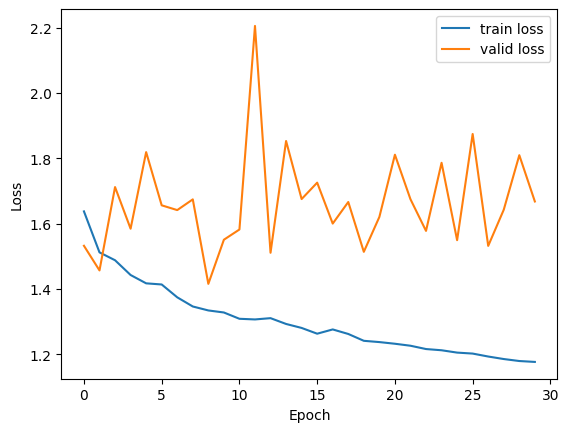

In [397]:
plt.plot(range(N ), loss_train_hist, label = 'train loss')
plt.plot(range(N ), loss_valid_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

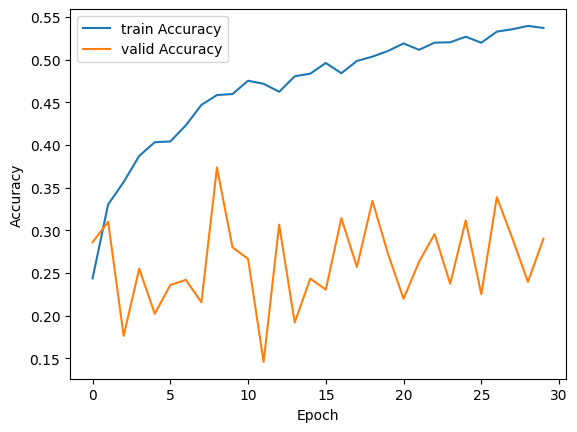

In [398]:
plt.plot(range(N), acc_train_hist, label = 'train Accuracy')
plt.plot(range(N), acc_valid_hist, label = 'valid Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()